# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [ ]:
# can comment out after executing
!unzip processed_celeba_small.zip

Archive:  processed_celeba_small.zip
replace processed_celeba_small/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [1]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [2]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import os

In [3]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader# resize and normalize the images
    transform = transforms.Compose([transforms.Resize(image_size),transforms.CenterCrop(image_size), # resize the images ti image size
                                    transforms.ToTensor()])
    
    image_path = './' + data_dir
    
    train_path = os.path.join(image_path)

    # define datasets using ImageFolder
    
    train_dataset = datasets.ImageFolder(train_path, transform)

    # create and return DataLoaders
    
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

    return train_loader
    


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [4]:
# Define function hyperparameters
batch_size = 32 #128 32 20 16 
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

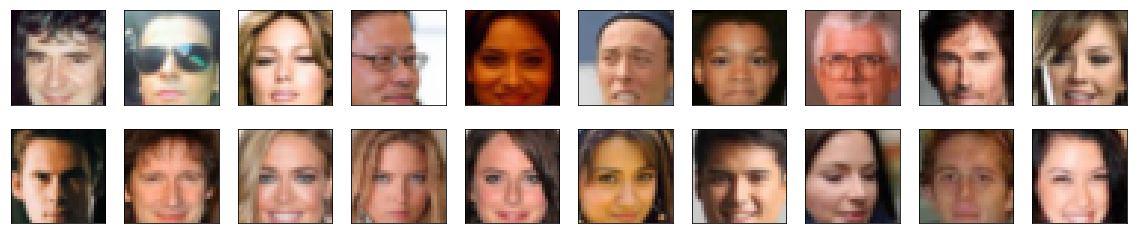

In [5]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [6]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    
    x = x *(max - min) + min
    
    return x


In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9922)
Max:  tensor(0.9137)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [8]:
import torch.nn as nn
import torch.nn.functional as F

In [9]:
# Helper conv function

def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)


In [10]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        
        self.conv_dim = conv_dim
        
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) # x, y = 32, conv_dim
        self.conv2 = conv(conv_dim, conv_dim*2, 4) # (16, 16, conv_dim*2)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4) # (8, 8, conv_dim*4)
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4) # (4, 4, conv_dim*8)
        
        
        self.fc = nn.Linear(conv_dim*8*2*2, 1) 
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        
        # all hidden layers + leaky relu activation
        
        out = F.leaky_relu(self.conv1(x), 0.2)
        out = F.leaky_relu(self.conv2(out), 0.2)
        out = F.leaky_relu(self.conv3(out), 0.2)
        out = F.leaky_relu(self.conv4(out), 0.2)
        
        # flatten
        out = out.view(-1, self.conv_dim*8*2*2)
        
        # final output layer
        out = self.fc(out)  
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [11]:
# Helper deconv function

def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    # create a sequence of transpose + optional batch norm layers
    layers = []
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                                              kernel_size, stride, padding, bias=False)
    # append transpose convolutional layer
    layers.append(transpose_conv_layer)
    
    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [12]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        # first, fully-connected layer
        self.fc = nn.Linear(z_size, conv_dim*8*2*2)

        # transpose conv layers
        
        self.t_conv1 = deconv(conv_dim*8, conv_dim*4, 4)
        self.t_conv2 = deconv(conv_dim*4, conv_dim*2, 4)
        self.t_conv3 = deconv(conv_dim*2, conv_dim, 4)
        self.t_conv4 = deconv(conv_dim, 3, 4, batch_norm=False)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        
        # define feedforward behavior
        
        out = self.fc(x)
        out = out.view(-1, self.conv_dim*8, 2, 2) # (batch_size, depth, 4, 4)
        
        out = F.relu(self.t_conv1(out))
        out = F.relu(self.t_conv2(out))
        out = F.relu(self.t_conv3(out))
        
        # last layer: tanh activation instead of relu
        
        out = self.t_conv4(out)
        
        out = F.tanh(out)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [13]:
from torch.nn import init

def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    init_gain = 0.02
    
    # TODO: Apply initial weights to convolutional and linear layers
    
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        
        init.normal_(m.weight.data, 0.0, init_gain)
        
        if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
                
    elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
        init.normal_(m.weight.data, 1.0, init_gain)
        init.constant_(m.bias.data, 0.0)
      

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [15]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=1024, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=1024, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [17]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    
    batch_size = D_out.size(0)
    labels = torch.ones(batch_size)
    
    # move labels to GPU if available 
    
    if train_on_gpu:
        labels = labels.cuda()
        
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)

    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''

    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    
    if train_on_gpu:
        labels = labels.cuda()
        
        
    criterion = nn.BCEWithLogitsLoss()
    
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [18]:
import torch.optim as optim

# params
lr = 0.0002
beta1=0.5
beta2=0.999 # default value

# Create optimizers for the discriminator D and generator G

d_optimizer = optim.Adam(D.parameters(),lr , [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(),lr , [beta1, beta2])


---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [19]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            d_optimizer.zero_grad()
            
            # 1. Train the discriminator on real and fake images
            
                    # 1. Train with real images

            # Compute the discriminator losses on real images 
            
            if train_on_gpu:
                real_images = real_images.cuda()

            D_real = D(real_images)
            d_real_loss = real_loss(D_real)

            # 2. Train with fake images

            # Generate fake images
            
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            
            z = torch.from_numpy(z).float()
            
            # move x to GPU, if available
            
            if train_on_gpu:
                z = z.cuda()
                
            fake_images = G(z)

            # Compute the discriminator losses on fake images  
            
            D_fake = D(fake_images)
            
            d_fake_loss = fake_loss(D_fake)

            # add up loss and perform backprop
            
            d_loss = d_real_loss + d_fake_loss
            
            d_loss.backward()
            d_optimizer.step()
            

            # 2. Train the generator with an adversarial loss
            
            g_optimizer.zero_grad()

            # 1. Train with fake images and flipped labels

            # Generate fake images
            
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            
            if train_on_gpu:
                z = z.cuda()
                
            fake_images = G(z)

            # Compute the discriminator losses on fake images 
            # using flipped labels!
            
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake) # use real loss to flip labels

            # perform backprop
            g_loss.backward()
            g_optimizer.step()
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [20]:
# set number of epochs 
n_epochs = 50


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   50] | d_loss: 1.3348 | g_loss: 1.0286
Epoch [    1/   50] | d_loss: 0.1008 | g_loss: 5.5101
Epoch [    1/   50] | d_loss: 0.4422 | g_loss: 4.2574
Epoch [    1/   50] | d_loss: 0.1233 | g_loss: 4.7456
Epoch [    1/   50] | d_loss: 0.6534 | g_loss: 3.1274
Epoch [    1/   50] | d_loss: 0.4606 | g_loss: 4.1374
Epoch [    1/   50] | d_loss: 0.2578 | g_loss: 3.5833
Epoch [    1/   50] | d_loss: 0.5678 | g_loss: 4.7635
Epoch [    1/   50] | d_loss: 0.3849 | g_loss: 4.4430
Epoch [    1/   50] | d_loss: 0.4511 | g_loss: 3.4351
Epoch [    1/   50] | d_loss: 0.8305 | g_loss: 2.4246
Epoch [    1/   50] | d_loss: 0.4230 | g_loss: 4.1225
Epoch [    1/   50] | d_loss: 0.3012 | g_loss: 3.5851
Epoch [    1/   50] | d_loss: 0.3803 | g_loss: 1.9013
Epoch [    1/   50] | d_loss: 0.6529 | g_loss: 3.1899
Epoch [    1/   50] | d_loss: 0.2853 | g_loss: 4.2017
Epoch [    1/   50] | d_loss: 0.3624 | g_loss: 3.1851
Epoch [    1/   50] | d_loss: 0.3692 | g_loss: 3.0499
Epoch [    1/   50] | d_loss

Epoch [    3/   50] | d_loss: 0.7211 | g_loss: 2.5749
Epoch [    3/   50] | d_loss: 0.7667 | g_loss: 3.3295
Epoch [    3/   50] | d_loss: 0.5360 | g_loss: 3.1209
Epoch [    3/   50] | d_loss: 0.2908 | g_loss: 2.3533
Epoch [    3/   50] | d_loss: 0.3580 | g_loss: 2.0588
Epoch [    3/   50] | d_loss: 0.7676 | g_loss: 1.5252
Epoch [    3/   50] | d_loss: 1.0447 | g_loss: 1.1378
Epoch [    3/   50] | d_loss: 0.8837 | g_loss: 3.5387
Epoch [    3/   50] | d_loss: 0.5676 | g_loss: 1.8796
Epoch [    3/   50] | d_loss: 0.9641 | g_loss: 3.5095
Epoch [    3/   50] | d_loss: 0.4133 | g_loss: 2.8467
Epoch [    3/   50] | d_loss: 0.6874 | g_loss: 2.6144
Epoch [    3/   50] | d_loss: 0.5993 | g_loss: 2.3262
Epoch [    3/   50] | d_loss: 0.6209 | g_loss: 2.8978
Epoch [    3/   50] | d_loss: 0.3329 | g_loss: 2.3643
Epoch [    3/   50] | d_loss: 0.8714 | g_loss: 0.8608
Epoch [    3/   50] | d_loss: 0.5354 | g_loss: 2.5842
Epoch [    3/   50] | d_loss: 1.1053 | g_loss: 3.1039
Epoch [    3/   50] | d_loss

Epoch [    6/   50] | d_loss: 0.8387 | g_loss: 2.5897
Epoch [    6/   50] | d_loss: 0.3154 | g_loss: 2.5830
Epoch [    6/   50] | d_loss: 0.1999 | g_loss: 4.0935
Epoch [    6/   50] | d_loss: 0.2759 | g_loss: 3.8010
Epoch [    6/   50] | d_loss: 0.4309 | g_loss: 2.7982
Epoch [    6/   50] | d_loss: 0.3872 | g_loss: 1.9116
Epoch [    6/   50] | d_loss: 0.2752 | g_loss: 2.4101
Epoch [    6/   50] | d_loss: 0.2550 | g_loss: 3.2832
Epoch [    6/   50] | d_loss: 0.4164 | g_loss: 3.4268
Epoch [    6/   50] | d_loss: 1.2268 | g_loss: 4.6484
Epoch [    6/   50] | d_loss: 0.6225 | g_loss: 2.9338
Epoch [    6/   50] | d_loss: 0.5034 | g_loss: 3.8067
Epoch [    6/   50] | d_loss: 0.4985 | g_loss: 3.4469
Epoch [    6/   50] | d_loss: 1.0008 | g_loss: 7.5545
Epoch [    6/   50] | d_loss: 0.3464 | g_loss: 1.6827
Epoch [    6/   50] | d_loss: 0.2032 | g_loss: 2.0674
Epoch [    6/   50] | d_loss: 0.4133 | g_loss: 5.1139
Epoch [    6/   50] | d_loss: 0.4308 | g_loss: 2.6228
Epoch [    6/   50] | d_loss

Epoch [    9/   50] | d_loss: 0.4187 | g_loss: 3.3934
Epoch [    9/   50] | d_loss: 0.3445 | g_loss: 3.3686
Epoch [    9/   50] | d_loss: 0.4048 | g_loss: 1.5313
Epoch [    9/   50] | d_loss: 0.2387 | g_loss: 2.7907
Epoch [    9/   50] | d_loss: 0.1946 | g_loss: 2.4192
Epoch [    9/   50] | d_loss: 1.0314 | g_loss: 6.0595
Epoch [    9/   50] | d_loss: 0.3912 | g_loss: 4.0913
Epoch [    9/   50] | d_loss: 0.2347 | g_loss: 2.6521
Epoch [    9/   50] | d_loss: 0.3296 | g_loss: 3.4742
Epoch [    9/   50] | d_loss: 0.2865 | g_loss: 2.9831
Epoch [    9/   50] | d_loss: 0.2858 | g_loss: 5.0768
Epoch [    9/   50] | d_loss: 0.4475 | g_loss: 2.2177
Epoch [    9/   50] | d_loss: 0.4012 | g_loss: 3.0763
Epoch [    9/   50] | d_loss: 0.3297 | g_loss: 5.4762
Epoch [    9/   50] | d_loss: 0.1970 | g_loss: 3.6115
Epoch [    9/   50] | d_loss: 0.3811 | g_loss: 4.2917
Epoch [    9/   50] | d_loss: 0.2695 | g_loss: 3.6986
Epoch [    9/   50] | d_loss: 0.1286 | g_loss: 5.1345
Epoch [    9/   50] | d_loss

Epoch [   11/   50] | d_loss: 0.0888 | g_loss: 5.4229
Epoch [   11/   50] | d_loss: 0.1758 | g_loss: 5.4206
Epoch [   11/   50] | d_loss: 0.2221 | g_loss: 3.5054
Epoch [   11/   50] | d_loss: 0.0889 | g_loss: 3.6044
Epoch [   11/   50] | d_loss: 0.0278 | g_loss: 3.5928
Epoch [   11/   50] | d_loss: 0.4661 | g_loss: 3.9075
Epoch [   11/   50] | d_loss: 0.2651 | g_loss: 2.1770
Epoch [   11/   50] | d_loss: 0.4964 | g_loss: 5.1601
Epoch [   11/   50] | d_loss: 0.0680 | g_loss: 4.4144
Epoch [   11/   50] | d_loss: 0.1580 | g_loss: 5.0282
Epoch [   11/   50] | d_loss: 0.1156 | g_loss: 5.6666
Epoch [   11/   50] | d_loss: 0.2839 | g_loss: 2.8127
Epoch [   11/   50] | d_loss: 0.2512 | g_loss: 2.6369
Epoch [   11/   50] | d_loss: 0.1907 | g_loss: 4.2846
Epoch [   11/   50] | d_loss: 0.2154 | g_loss: 4.8056
Epoch [   11/   50] | d_loss: 0.1383 | g_loss: 5.2423
Epoch [   11/   50] | d_loss: 0.1913 | g_loss: 3.9508
Epoch [   11/   50] | d_loss: 0.1663 | g_loss: 4.3598
Epoch [   11/   50] | d_loss

Epoch [   14/   50] | d_loss: 0.5760 | g_loss: 2.1623
Epoch [   14/   50] | d_loss: 0.1604 | g_loss: 4.5686
Epoch [   14/   50] | d_loss: 0.1732 | g_loss: 3.1885
Epoch [   14/   50] | d_loss: 0.8124 | g_loss: 3.7733
Epoch [   14/   50] | d_loss: 0.4542 | g_loss: 5.2870
Epoch [   14/   50] | d_loss: 0.2613 | g_loss: 2.8860
Epoch [   14/   50] | d_loss: 0.0868 | g_loss: 3.2447
Epoch [   14/   50] | d_loss: 0.1502 | g_loss: 3.7205
Epoch [   14/   50] | d_loss: 0.0706 | g_loss: 5.1070
Epoch [   14/   50] | d_loss: 0.0823 | g_loss: 5.7873
Epoch [   14/   50] | d_loss: 0.1308 | g_loss: 4.4338
Epoch [   14/   50] | d_loss: 0.2077 | g_loss: 3.2880
Epoch [   14/   50] | d_loss: 0.6644 | g_loss: 5.1190
Epoch [   14/   50] | d_loss: 0.4010 | g_loss: 4.3370
Epoch [   14/   50] | d_loss: 0.2381 | g_loss: 2.8607
Epoch [   14/   50] | d_loss: 0.1478 | g_loss: 3.6673
Epoch [   14/   50] | d_loss: 0.1065 | g_loss: 6.9289
Epoch [   14/   50] | d_loss: 0.1345 | g_loss: 6.1561
Epoch [   14/   50] | d_loss

Epoch [   17/   50] | d_loss: 0.2898 | g_loss: 3.6566
Epoch [   17/   50] | d_loss: 0.2963 | g_loss: 4.2881
Epoch [   17/   50] | d_loss: 0.0716 | g_loss: 6.3319
Epoch [   17/   50] | d_loss: 0.0568 | g_loss: 3.6226
Epoch [   17/   50] | d_loss: 0.0436 | g_loss: 4.9173
Epoch [   17/   50] | d_loss: 0.0958 | g_loss: 4.4066
Epoch [   17/   50] | d_loss: 0.0880 | g_loss: 4.6864
Epoch [   17/   50] | d_loss: 0.1438 | g_loss: 6.9809
Epoch [   17/   50] | d_loss: 0.1693 | g_loss: 4.2126
Epoch [   17/   50] | d_loss: 0.0479 | g_loss: 4.4350
Epoch [   17/   50] | d_loss: 0.1069 | g_loss: 4.6881
Epoch [   17/   50] | d_loss: 1.5992 | g_loss: 8.8414
Epoch [   17/   50] | d_loss: 0.0303 | g_loss: 6.0152
Epoch [   17/   50] | d_loss: 0.0794 | g_loss: 5.0922
Epoch [   17/   50] | d_loss: 0.1100 | g_loss: 6.0205
Epoch [   17/   50] | d_loss: 0.1132 | g_loss: 6.6820
Epoch [   17/   50] | d_loss: 0.0491 | g_loss: 5.5942
Epoch [   17/   50] | d_loss: 0.0380 | g_loss: 8.2574
Epoch [   17/   50] | d_loss

Epoch [   19/   50] | d_loss: 0.0438 | g_loss: 3.7257
Epoch [   19/   50] | d_loss: 0.1396 | g_loss: 7.5778
Epoch [   19/   50] | d_loss: 0.0139 | g_loss: 3.3805
Epoch [   19/   50] | d_loss: 0.2479 | g_loss: 7.6825
Epoch [   19/   50] | d_loss: 0.0734 | g_loss: 5.0034
Epoch [   19/   50] | d_loss: 0.1142 | g_loss: 4.7304
Epoch [   19/   50] | d_loss: 0.0966 | g_loss: 4.4518
Epoch [   19/   50] | d_loss: 0.1000 | g_loss: 4.9165
Epoch [   19/   50] | d_loss: 0.0754 | g_loss: 4.9614
Epoch [   19/   50] | d_loss: 0.0147 | g_loss: 4.6649
Epoch [   19/   50] | d_loss: 0.1287 | g_loss: 6.8196
Epoch [   19/   50] | d_loss: 1.1673 | g_loss: 1.3123
Epoch [   19/   50] | d_loss: 0.0643 | g_loss: 3.0763
Epoch [   19/   50] | d_loss: 0.0841 | g_loss: 5.7654
Epoch [   19/   50] | d_loss: 1.4668 | g_loss: 11.4655
Epoch [   19/   50] | d_loss: 0.1550 | g_loss: 5.1111
Epoch [   19/   50] | d_loss: 0.0830 | g_loss: 5.1227
Epoch [   19/   50] | d_loss: 0.0799 | g_loss: 5.1195
Epoch [   19/   50] | d_los

Epoch [   22/   50] | d_loss: 0.0319 | g_loss: 5.1090
Epoch [   22/   50] | d_loss: 0.0875 | g_loss: 4.0643
Epoch [   22/   50] | d_loss: 0.0472 | g_loss: 8.0439
Epoch [   22/   50] | d_loss: 0.0935 | g_loss: 3.8885
Epoch [   22/   50] | d_loss: 0.0612 | g_loss: 3.5456
Epoch [   22/   50] | d_loss: 0.0806 | g_loss: 3.3436
Epoch [   22/   50] | d_loss: 0.2840 | g_loss: 3.4056
Epoch [   22/   50] | d_loss: 0.0372 | g_loss: 8.6482
Epoch [   22/   50] | d_loss: 0.2202 | g_loss: 8.0812
Epoch [   22/   50] | d_loss: 0.0450 | g_loss: 6.6647
Epoch [   22/   50] | d_loss: 0.0197 | g_loss: 3.8691
Epoch [   22/   50] | d_loss: 0.0759 | g_loss: 5.5758
Epoch [   22/   50] | d_loss: 0.1555 | g_loss: 4.8509
Epoch [   22/   50] | d_loss: 0.0160 | g_loss: 7.0867
Epoch [   22/   50] | d_loss: 0.0830 | g_loss: 3.6831
Epoch [   22/   50] | d_loss: 0.0086 | g_loss: 3.3583
Epoch [   22/   50] | d_loss: 0.0405 | g_loss: 5.6875
Epoch [   22/   50] | d_loss: 0.7313 | g_loss: 5.0921
Epoch [   22/   50] | d_loss

Epoch [   25/   50] | d_loss: 0.1987 | g_loss: 3.6504
Epoch [   25/   50] | d_loss: 0.0226 | g_loss: 6.1795
Epoch [   25/   50] | d_loss: 0.0318 | g_loss: 6.7431
Epoch [   25/   50] | d_loss: 0.2332 | g_loss: 5.6866
Epoch [   25/   50] | d_loss: 0.0542 | g_loss: 7.1688
Epoch [   25/   50] | d_loss: 0.0494 | g_loss: 4.7380
Epoch [   25/   50] | d_loss: 1.4004 | g_loss: 10.2119
Epoch [   25/   50] | d_loss: 0.0778 | g_loss: 3.6749
Epoch [   25/   50] | d_loss: 0.0584 | g_loss: 7.0177
Epoch [   25/   50] | d_loss: 0.9384 | g_loss: 2.6253
Epoch [   25/   50] | d_loss: 0.0342 | g_loss: 5.5825
Epoch [   25/   50] | d_loss: 0.1319 | g_loss: 3.7580
Epoch [   25/   50] | d_loss: 0.0489 | g_loss: 5.9960
Epoch [   25/   50] | d_loss: 0.0255 | g_loss: 4.8603
Epoch [   25/   50] | d_loss: 0.1816 | g_loss: 6.1916
Epoch [   25/   50] | d_loss: 0.1666 | g_loss: 5.0614
Epoch [   25/   50] | d_loss: 0.0149 | g_loss: 6.7275
Epoch [   25/   50] | d_loss: 0.1231 | g_loss: 5.1800
Epoch [   25/   50] | d_los

Epoch [   27/   50] | d_loss: 0.2735 | g_loss: 2.1761
Epoch [   27/   50] | d_loss: 0.0505 | g_loss: 4.1381
Epoch [   27/   50] | d_loss: 0.0534 | g_loss: 6.7253
Epoch [   27/   50] | d_loss: 0.0374 | g_loss: 6.3169
Epoch [   27/   50] | d_loss: 0.1225 | g_loss: 3.7125
Epoch [   27/   50] | d_loss: 0.0478 | g_loss: 3.8244
Epoch [   27/   50] | d_loss: 0.1115 | g_loss: 6.2156
Epoch [   27/   50] | d_loss: 0.1012 | g_loss: 5.5381
Epoch [   27/   50] | d_loss: 0.0093 | g_loss: 5.3512
Epoch [   27/   50] | d_loss: 0.5491 | g_loss: 7.9611
Epoch [   27/   50] | d_loss: 0.0244 | g_loss: 3.9684
Epoch [   27/   50] | d_loss: 0.5535 | g_loss: 3.1284
Epoch [   27/   50] | d_loss: 0.3859 | g_loss: 7.4641
Epoch [   27/   50] | d_loss: 0.0789 | g_loss: 6.6600
Epoch [   27/   50] | d_loss: 0.0712 | g_loss: 5.8222
Epoch [   27/   50] | d_loss: 0.1533 | g_loss: 5.9241
Epoch [   27/   50] | d_loss: 0.0948 | g_loss: 3.3029
Epoch [   27/   50] | d_loss: 0.0702 | g_loss: 4.7971
Epoch [   27/   50] | d_loss

Epoch [   30/   50] | d_loss: 0.0678 | g_loss: 6.3542
Epoch [   30/   50] | d_loss: 0.0329 | g_loss: 4.3107
Epoch [   30/   50] | d_loss: 0.0217 | g_loss: 7.5547
Epoch [   30/   50] | d_loss: 0.3481 | g_loss: 6.1798
Epoch [   30/   50] | d_loss: 0.0314 | g_loss: 6.2841
Epoch [   30/   50] | d_loss: 0.0140 | g_loss: 5.9808
Epoch [   30/   50] | d_loss: 0.0494 | g_loss: 4.4092
Epoch [   30/   50] | d_loss: 0.0907 | g_loss: 4.6839
Epoch [   30/   50] | d_loss: 0.1356 | g_loss: 3.5779
Epoch [   30/   50] | d_loss: 0.0434 | g_loss: 6.2530
Epoch [   30/   50] | d_loss: 0.0134 | g_loss: 6.5530
Epoch [   30/   50] | d_loss: 0.1847 | g_loss: 5.9692
Epoch [   30/   50] | d_loss: 0.0249 | g_loss: 5.8009
Epoch [   30/   50] | d_loss: 0.2154 | g_loss: 6.4661
Epoch [   30/   50] | d_loss: 0.0080 | g_loss: 6.0338
Epoch [   30/   50] | d_loss: 0.1015 | g_loss: 5.1863
Epoch [   30/   50] | d_loss: 0.0615 | g_loss: 4.8973
Epoch [   30/   50] | d_loss: 0.0726 | g_loss: 6.1911
Epoch [   30/   50] | d_loss

Epoch [   33/   50] | d_loss: 0.3799 | g_loss: 8.5906
Epoch [   33/   50] | d_loss: 0.1441 | g_loss: 5.2773
Epoch [   33/   50] | d_loss: 0.0958 | g_loss: 4.1436
Epoch [   33/   50] | d_loss: 0.1269 | g_loss: 3.4378
Epoch [   33/   50] | d_loss: 0.0466 | g_loss: 6.0139
Epoch [   33/   50] | d_loss: 0.1112 | g_loss: 6.2658
Epoch [   33/   50] | d_loss: 0.1331 | g_loss: 5.8360
Epoch [   33/   50] | d_loss: 0.1596 | g_loss: 3.9869
Epoch [   33/   50] | d_loss: 0.0072 | g_loss: 5.5183
Epoch [   33/   50] | d_loss: 0.2037 | g_loss: 4.0983
Epoch [   33/   50] | d_loss: 0.1009 | g_loss: 4.3725
Epoch [   33/   50] | d_loss: 0.0209 | g_loss: 5.9967
Epoch [   33/   50] | d_loss: 0.0056 | g_loss: 4.3489
Epoch [   33/   50] | d_loss: 0.0571 | g_loss: 7.6926
Epoch [   33/   50] | d_loss: 0.0069 | g_loss: 5.9985
Epoch [   33/   50] | d_loss: 0.0184 | g_loss: 9.1851
Epoch [   33/   50] | d_loss: 0.0659 | g_loss: 7.0750
Epoch [   33/   50] | d_loss: 0.0123 | g_loss: 4.8097
Epoch [   33/   50] | d_loss

Epoch [   35/   50] | d_loss: 0.2479 | g_loss: 2.8955
Epoch [   35/   50] | d_loss: 0.0235 | g_loss: 7.4866
Epoch [   35/   50] | d_loss: 0.0219 | g_loss: 6.7663
Epoch [   35/   50] | d_loss: 0.2626 | g_loss: 7.1795
Epoch [   35/   50] | d_loss: 0.0646 | g_loss: 5.3326
Epoch [   35/   50] | d_loss: 0.0091 | g_loss: 7.9028
Epoch [   35/   50] | d_loss: 0.0414 | g_loss: 6.2390
Epoch [   35/   50] | d_loss: 0.0373 | g_loss: 5.2446
Epoch [   35/   50] | d_loss: 0.0629 | g_loss: 6.7919
Epoch [   35/   50] | d_loss: 0.0962 | g_loss: 3.6622
Epoch [   35/   50] | d_loss: 0.0327 | g_loss: 8.2780
Epoch [   35/   50] | d_loss: 0.0964 | g_loss: 7.9622
Epoch [   35/   50] | d_loss: 0.0037 | g_loss: 8.6065
Epoch [   35/   50] | d_loss: 0.0952 | g_loss: 5.6141
Epoch [   35/   50] | d_loss: 0.0066 | g_loss: 4.6680
Epoch [   35/   50] | d_loss: 0.0252 | g_loss: 5.6502
Epoch [   35/   50] | d_loss: 0.0835 | g_loss: 5.7867
Epoch [   35/   50] | d_loss: 0.0519 | g_loss: 5.4216
Epoch [   35/   50] | d_loss

Epoch [   38/   50] | d_loss: 0.0637 | g_loss: 6.7515
Epoch [   38/   50] | d_loss: 0.0764 | g_loss: 4.8430
Epoch [   38/   50] | d_loss: 0.0318 | g_loss: 8.1396
Epoch [   38/   50] | d_loss: 0.0027 | g_loss: 6.9430
Epoch [   38/   50] | d_loss: 0.0144 | g_loss: 6.0384
Epoch [   38/   50] | d_loss: 0.0654 | g_loss: 5.9781
Epoch [   38/   50] | d_loss: 0.4228 | g_loss: 5.4083
Epoch [   38/   50] | d_loss: 0.0763 | g_loss: 4.9332
Epoch [   38/   50] | d_loss: 0.2171 | g_loss: 10.0025
Epoch [   38/   50] | d_loss: 0.0380 | g_loss: 7.1224
Epoch [   38/   50] | d_loss: 0.0591 | g_loss: 6.2827
Epoch [   38/   50] | d_loss: 0.1296 | g_loss: 5.6021
Epoch [   38/   50] | d_loss: 0.3275 | g_loss: 6.7674
Epoch [   38/   50] | d_loss: 0.1070 | g_loss: 7.5430
Epoch [   38/   50] | d_loss: 0.1369 | g_loss: 4.5240
Epoch [   38/   50] | d_loss: 0.0192 | g_loss: 9.0155
Epoch [   38/   50] | d_loss: 0.0093 | g_loss: 6.8117
Epoch [   38/   50] | d_loss: 0.0179 | g_loss: 7.2010
Epoch [   38/   50] | d_los

Epoch [   41/   50] | d_loss: 0.1038 | g_loss: 7.6700
Epoch [   41/   50] | d_loss: 0.0209 | g_loss: 4.7234
Epoch [   41/   50] | d_loss: 0.5591 | g_loss: 6.2232
Epoch [   41/   50] | d_loss: 0.0188 | g_loss: 6.7547
Epoch [   41/   50] | d_loss: 0.0181 | g_loss: 8.6138
Epoch [   41/   50] | d_loss: 0.1777 | g_loss: 2.9516
Epoch [   41/   50] | d_loss: 0.3853 | g_loss: 3.7536
Epoch [   41/   50] | d_loss: 0.0510 | g_loss: 5.0052
Epoch [   41/   50] | d_loss: 0.0077 | g_loss: 6.9854
Epoch [   41/   50] | d_loss: 0.0238 | g_loss: 3.4277
Epoch [   41/   50] | d_loss: 0.0311 | g_loss: 6.3153
Epoch [   41/   50] | d_loss: 0.0428 | g_loss: 5.2142
Epoch [   41/   50] | d_loss: 0.0632 | g_loss: 8.2919
Epoch [   41/   50] | d_loss: 0.0176 | g_loss: 5.6496
Epoch [   41/   50] | d_loss: 0.0165 | g_loss: 4.3731
Epoch [   41/   50] | d_loss: 0.0719 | g_loss: 4.2821
Epoch [   41/   50] | d_loss: 0.2200 | g_loss: 5.1952
Epoch [   41/   50] | d_loss: 0.0335 | g_loss: 4.4161
Epoch [   41/   50] | d_loss

Epoch [   43/   50] | d_loss: 0.0248 | g_loss: 7.0176
Epoch [   43/   50] | d_loss: 0.0152 | g_loss: 6.2284
Epoch [   43/   50] | d_loss: 0.0098 | g_loss: 4.6561
Epoch [   43/   50] | d_loss: 0.0312 | g_loss: 7.1537
Epoch [   43/   50] | d_loss: 0.1215 | g_loss: 3.7445
Epoch [   43/   50] | d_loss: 0.0246 | g_loss: 7.8768
Epoch [   43/   50] | d_loss: 0.0847 | g_loss: 3.8894
Epoch [   43/   50] | d_loss: 0.0931 | g_loss: 5.8775
Epoch [   43/   50] | d_loss: 0.1408 | g_loss: 6.2428
Epoch [   43/   50] | d_loss: 0.0279 | g_loss: 5.1352
Epoch [   43/   50] | d_loss: 0.0143 | g_loss: 5.0033
Epoch [   43/   50] | d_loss: 0.0317 | g_loss: 5.2652
Epoch [   43/   50] | d_loss: 0.0694 | g_loss: 9.4709
Epoch [   43/   50] | d_loss: 1.0359 | g_loss: 8.4830
Epoch [   43/   50] | d_loss: 0.0311 | g_loss: 4.5093
Epoch [   43/   50] | d_loss: 0.0134 | g_loss: 5.2128
Epoch [   43/   50] | d_loss: 0.0865 | g_loss: 3.8699
Epoch [   43/   50] | d_loss: 0.0326 | g_loss: 6.7957
Epoch [   43/   50] | d_loss

Epoch [   46/   50] | d_loss: 0.2158 | g_loss: 5.8883
Epoch [   46/   50] | d_loss: 0.0120 | g_loss: 7.4543
Epoch [   46/   50] | d_loss: 0.1708 | g_loss: 8.0914
Epoch [   46/   50] | d_loss: 0.0342 | g_loss: 6.0250
Epoch [   46/   50] | d_loss: 0.0416 | g_loss: 6.8647
Epoch [   46/   50] | d_loss: 0.0020 | g_loss: 5.6641
Epoch [   46/   50] | d_loss: 0.0185 | g_loss: 5.4536
Epoch [   46/   50] | d_loss: 0.0160 | g_loss: 8.7065
Epoch [   46/   50] | d_loss: 0.0260 | g_loss: 5.7581
Epoch [   46/   50] | d_loss: 0.3177 | g_loss: 8.1646
Epoch [   46/   50] | d_loss: 0.0046 | g_loss: 5.3843
Epoch [   46/   50] | d_loss: 0.0122 | g_loss: 2.5912
Epoch [   46/   50] | d_loss: 0.0116 | g_loss: 7.0881
Epoch [   46/   50] | d_loss: 0.0069 | g_loss: 10.2552
Epoch [   46/   50] | d_loss: 0.0067 | g_loss: 5.9864
Epoch [   46/   50] | d_loss: 0.0178 | g_loss: 11.2128
Epoch [   46/   50] | d_loss: 0.1004 | g_loss: 9.1433
Epoch [   46/   50] | d_loss: 0.0464 | g_loss: 8.1462
Epoch [   46/   50] | d_lo

Epoch [   49/   50] | d_loss: 0.0365 | g_loss: 2.0051
Epoch [   49/   50] | d_loss: 0.0184 | g_loss: 9.6935
Epoch [   49/   50] | d_loss: 0.1112 | g_loss: 7.2357
Epoch [   49/   50] | d_loss: 0.0236 | g_loss: 6.5905
Epoch [   49/   50] | d_loss: 0.0064 | g_loss: 8.2690
Epoch [   49/   50] | d_loss: 0.1431 | g_loss: 8.0962
Epoch [   49/   50] | d_loss: 0.0075 | g_loss: 5.6505
Epoch [   49/   50] | d_loss: 0.1059 | g_loss: 9.3049
Epoch [   49/   50] | d_loss: 0.2257 | g_loss: 2.6015
Epoch [   49/   50] | d_loss: 0.0062 | g_loss: 7.7003
Epoch [   49/   50] | d_loss: 0.0138 | g_loss: 6.7629
Epoch [   49/   50] | d_loss: 0.0093 | g_loss: 8.4752
Epoch [   49/   50] | d_loss: 0.2811 | g_loss: 7.1218
Epoch [   49/   50] | d_loss: 0.0402 | g_loss: 9.2105
Epoch [   49/   50] | d_loss: 0.0352 | g_loss: 5.7144
Epoch [   49/   50] | d_loss: 0.0669 | g_loss: 6.4751
Epoch [   49/   50] | d_loss: 0.1598 | g_loss: 12.2874
Epoch [   49/   50] | d_loss: 0.0070 | g_loss: 4.7149
Epoch [   49/   50] | d_los

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

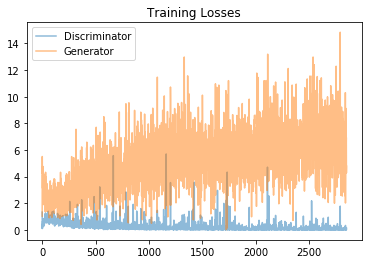

In [21]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [22]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [23]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

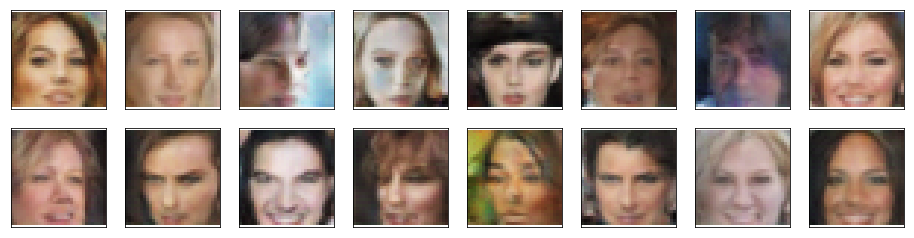

In [24]:
_ = view_samples(-1, samples)


### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** (Write your answer in this cell)

The dataset is biased; it is made of celebrity faces that are mostly white. To imrpvove on that, we need to add more images in the dataset so that it has almost equal number of white and non-white celebrity faces. 

We have found that model size plays a role feature learn process,for face generation task, we need to learn more complex features so we need a bigger network and a deeper one with more convolutional networks.

ADAM optimizer is the preferred optimizer for DCGAN model. I can try other optimizers for testing purpose. For example, one suggestion is to use SGD for discriminator and ADAM for generator. 

For number of epochs, this network needs much larger number of epochs to give a better result around thousands.


### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.